In [17]:
import bart
import cfl
import matplotlib.pyplot as plt
import numpy as np
import pdb

In [24]:
# simulate noiseless phantom data
nkyz = 256
nc = 8
ksp_ful_nonoise = bart.bart(1, 'phantom -x {} -k -s {}'.format(nkyz, nc))
ksp_ful_nonoise.shape

(256, 256, 1, 8)

In [55]:
# add noise
noi_var = 3000
ksp_ful = bart.bart(1, 'noise -n {}'.format(noi_var), ksp_ful_nonoise)
ksp_ful.shape

(256, 256, 1, 8)

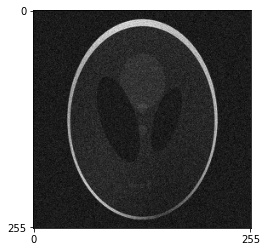

In [56]:
# root-sum-of-squares reconstruction from fully-sampled data
im_ful_coil = bart.bart(1, 'fft -i -u $(bart bitmask 0 1 2)', ksp_ful)
im_ful_rss = bart.bart(1, 'rss $(bart bitmask 3)', im_ful_coil)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_ful_rss), cmap='gray')

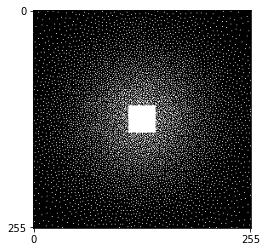

In [59]:
# construct poisson-disk undersampling mask
acc_y = 1.5
acc_z = 1.5
calib_dim = 32
mask_args = (nkyz, nkyz, acc_y, acc_z, calib_dim)
mask = bart.bart(1, 'poisson -Y {} -Z {} -y {} -z {} -C {} -v'.format(*mask_args))
mask = mask.reshape(nkyz, nkyz)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(mask), cmap='gray')

In [60]:
# apply mask to fully-sampled data
ksp = bart.bart(1, 'fmac', ksp_ful, mask)

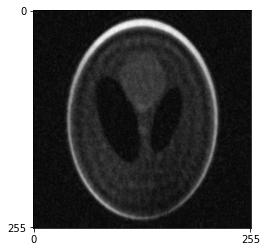

In [61]:
# check effect of masking on root-sum-of-squares recon
im_coil = bart.bart(1, 'fft -i -u $(bart bitmask 0 1 2)', ksp)
im_rss = bart.bart(1, 'rss $(bart bitmask 3)', im_coil)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_rss), cmap='gray')